# **Load the OPENAI API Key**

In [ ]:
import os
import yaml

with open("openai_key.yaml", 'r') as file:
    api_creds = yaml.safe_load(file)

os.environ["OPENAI_API_KEY"] = api_creds['openai_key']

# **Import Required Libraries**

In [5]:
import operator
from typing import Annotated, Sequence, TypedDict, Literal, List
from langchain.document_loaders import PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain_core.messages import BaseMessage, AIMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph

# **Document Processing**

In [6]:
guide_pdf_path = "/content/Guide-to-Litigation-in-India.pdf"
corporate_pdf_path = "/content/Legal-Compliance-&-Corporate-Laws-by-ICAI.pdf"

loader_guide = PyMuPDFLoader(guide_pdf_path)
loader_corporate = PyMuPDFLoader(corporate_pdf_path)

docs_guide = loader_guide.load()
docs_corporate = loader_corporate.load()
all_docs = docs_guide + docs_corporate

# Chunking & Indexing:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
chunks = text_splitter.split_documents(all_docs)

embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5")
vector_store = FAISS.from_documents(chunks, embeddings)

# **Agent State**

In [7]:
# 3. Define the Agent State structure
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

# **Create Agents**

In [8]:
# Query Agent
def query_agent_node(state: AgentState) -> AgentState:
    # Extract user query from the last message
    user_query = state["messages"][-1].content
    # Retrieve relevant document chunks (e.g., top 5 results)
    results = vector_store.similarity_search(user_query, k=5)
    # Concatenate the retrieved sections
    retrieved_text = "\n\n".join([doc.page_content for doc in results])
    # Prefix with an indicator to trigger the next agent
    content = f"RETRIEVAL COMPLETE\n\n{retrieved_text}"
    return {
        "messages": [AIMessage(content=content, name="Query_Agent")],
        "sender": "Query_Agent"
    }

# Summarization Agent
legal_summarization_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are a Legal Summarization Assistant. "
     "Your task is to provide a **concise and neutral summary** of the legal procedure in India. "
     "Summarize the **standard** steps of the process, avoiding unnecessary focus on **specific cases** like government lawsuits, foreign state cases, or mediation unless they are the primary focus. "
     "Ensure the response represents the **general filing process** fairly and does not highlight **exceptions** unless required. "
     "Use **clear and simple language** suitable for a general audience. "
     "Limit your response to **2-3 sentences** and ensure it begins with 'SUMMARY COMPLETE'."),
    MessagesPlaceholder(variable_name="messages"),
])

summarization_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
summarization_agent = legal_summarization_prompt | summarization_llm

def summarization_agent_node(state: AgentState) -> AgentState:
    result = summarization_agent.invoke(state)
    result_message = AIMessage(content=result.content, name="Summarization_Agent")
    return {
        "messages": [result_message],
        "sender": "Summarization_Agent"
    }

# **Agent Router Logic**

In [9]:
# Define Router Logic to direct the flow between agents
def router(state: AgentState) -> str:
    messages = state['messages']

    # Check the last message to determine next step
    last_message = messages[-1]

    # If the last message is from the Query Agent and contains retrieval results
    if isinstance(last_message, AIMessage) and "RETRIEVAL COMPLETE" in last_message.content:
        return "continue_to_summarization"

    # If we've already processed the query, end the workflow
    return "__end__"

# **Agent Graph**

In [16]:
# 6. Define the Multi-Agent Graph
workflow = StateGraph(AgentState)

# Add agent nodes
workflow.add_node("Query_Agent", query_agent_node)
workflow.add_node("Summarization_Agent", summarization_agent_node)

# Define edges from Query Agent based on router output.
workflow.add_conditional_edges(
    "Query_Agent",
    router,
    {
        "continue_to_summarization": "Summarization_Agent"
    }
)

# Define edges from Summarization Agent.
workflow.add_conditional_edges(
    "Summarization_Agent",
    router,
    {
        "__end__": END
    }
)

# Set the entry point for the workflow.
workflow.set_entry_point("Query_Agent")
agent_workflow = workflow.compile()

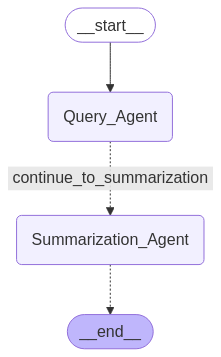

In [17]:
# Visualize the graph
from IPython.display import Image, display

display(Image(agent_workflow.get_graph().draw_mermaid_png()))

# **Test the Multi-Agent Legal Assistant**

In [18]:
# Test the Multi-Agent System
test_prompt = "What are the steps involved in filing a lawsuit against government authority in India?"
initial_state = {
    "messages": [HumanMessage(content=test_prompt)],
}

response = agent_workflow.invoke(initial_state)

# Display the final output (summary)
from IPython.display import display, Markdown
final_summary = response["messages"][-1].content.replace("SUMMARY COMPLETE: ", "", 1)

display(Markdown(final_summary))


In India, to file a lawsuit against a government authority, a plaintiff must first issue a written notice of at least two months detailing the dispute and claim. If urgent relief is needed, the suit can be filed sooner with the court's permission, but the defendant must be given a reasonable opportunity to respond. Additionally, civil proceedings against a foreign state require prior written consent from the Indian Government, which is granted only under specific conditions.